In this notebook we'll try out estimation of a transfer function using both time-domain and frequency domain data to see how they behave compared to each other. We start by loading the relevant packages. 

In [1]:
using ControlSystems, ControlSystemIdentification

Next, we define the system to be estimated
$$G_{test}(s) = \dfrac{12}{1.1s^2 + 0.0009s + 12}$$
This is a very lightly damped (resonant), second-order system.
We also discretize the system using ZoH and simulate some data from it with a Gaussian input $u$.

In [5]:
Gtest = tf([12], [1.1, 0.0009, 12]) # True system
h     = 0.01                        # Sample time
u     = randn(1, 10000)
Gd    = c2d(Gtest, h)
y,x,t = lsim(ss(Gd), u);

Next, we construct an `IdData` object and estimate the transfer function using a spectral method

In [6]:
d = iddata(y, u, h)
H = tfest(d, 0.05)[1]

FRD{LinRange{Float64}, Vector{ComplexF64}}(range(0.0, stop=314.1592653589793, length=10000), ComplexF64[1.0935765571773501 + 0.0im, 1.0905887329555453 - 0.018020115313899597im, 1.0825057636396738 - 0.0338910688417903im, 1.0714180287814683 - 0.046266962758021286im, 1.0597046991977337 - 0.054698778315634314im, 1.0496871739760076 - 0.05933478048987517im, 1.0437254991308713 - 0.06087765488554584im, 1.0438966232583493 - 0.06096435888910232im, 1.050449598067319 - 0.062381592335757845im, 1.0598120792945862 - 0.06789172493480819im  …  -0.00117662825812119 + 0.0016793590803703842im, -0.0005639336675556247 + 0.0010976855245630785im, -0.00029503881331847395 + 0.0005754729398392514im, -0.0002591773890115511 + 0.00022244620151602796im, -0.0003230812706458736 + 5.6546828676802156e-5im, -0.00038526527292189215 + 3.1212178429845665e-5im, -0.00039386735953652165 + 7.422642407620349e-5im, -0.00034359563092038547 + 0.0001158945962654049im, -0.00026532168738376184 + 0.00010902876551569861im, -0.0002075962

The spectral method yields a nonparametric estimate of the transfer function, i.e., the value of the transfer function for each frequency in a frequency vector. To obtain a parametric (rational) transfer function, we now call the function `arx` to estimate a (discrete time) model from time-domain data and the function `tfest` to obtain a model from the frequency-domain data. We use the function `d2c` to convert the estimated ARX model from discrete time to continuous time to allow us to compare the estimated poles.

In [7]:
G0 = tf([10], [1.0, 0.01, 10]) # initial guess
Gf = tfest(H, G0)              # Provide an initial guess for frequency domain
Gt = arx(d, 2, 1) |> d2c       # Provide the model order for time domain
Gf, Gt

Iter     Function value   Gradient norm 
     0     3.543040e-04     3.019514e-04


 * time: 0.026135921478271484


     5     2.670325e-04     2.790580e-04
 * time: 2.5670080184936523


    10     2.631463e-04     2.106043e-05
 * time: 2.7430288791656494


(TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
                       10.561605110252652
----------------------------------------------------------------
0.8389373541357882s^2 - 0.17419233003782977s + 9.454702722039931

Continuous-time transfer function model, TransferFunction{Continuous, ControlSystems.SisoRational{Float64}}
    0.027662230531591638s + 5.531888473273469
--------------------------------------------------
1.0s^2 - 0.005886149244355262s + 10.91783345853463

Continuous-time transfer function model)

We can inspect the error in the estimated poles of the system, and how well the static gain is estimated:

In [8]:
norm(pole(Gt)-pole(Gtest)), norm(pole(Gf)-pole(Gtest))

(0.00509597544499969, 0.1650821738536962)

In [9]:
dcgain(Gtest)[], dcgain(Gt)[], dcgain(Gf)[]

(1.0, 0.5066837201980866, 1.1170742667172826)

It appears as if the time-domain method is better at locating the poles, which is expected since AR-model estimation is considered a spectral-estimation method with "super resolution". The static gain is better estimated by the frequency-domain method.

We can also plot the bode curves of the systems:

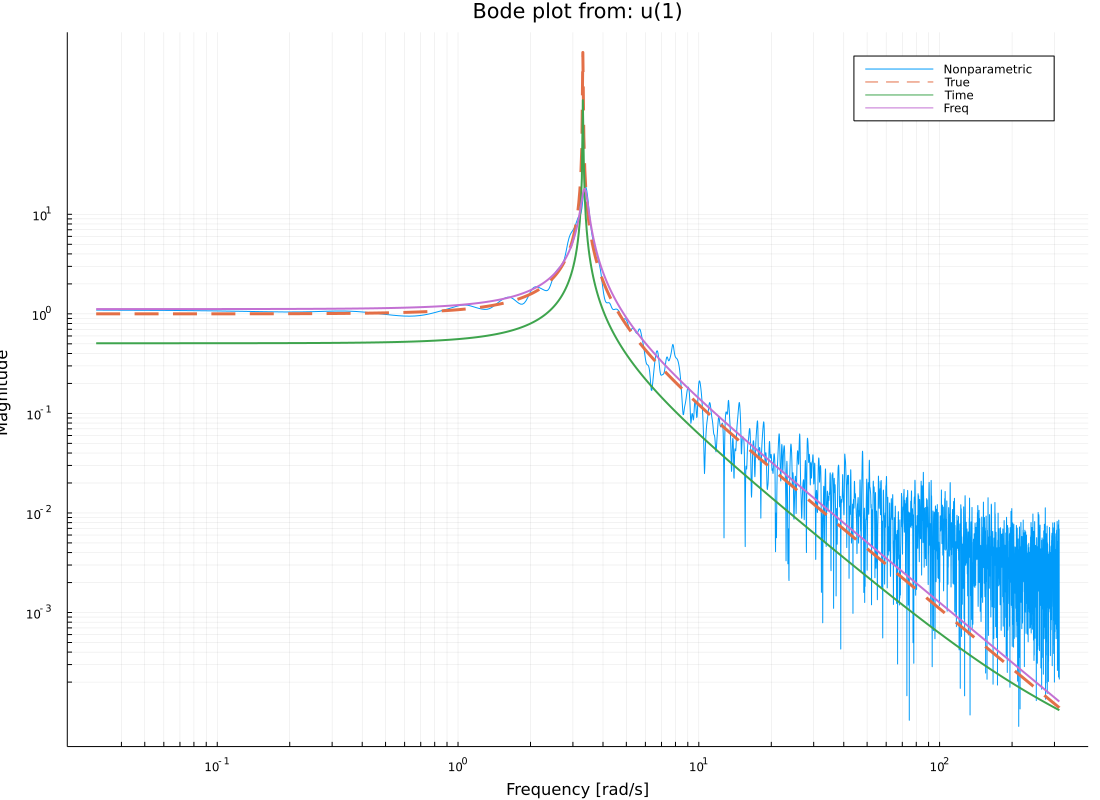

In [10]:
plot(H, lab="Nonparametric", legend=true)
bodeplot!(Gtest, H.w[2:end], lab="True", plotphase=false, l=(3,:dash))
bodeplot!(Gt,    H.w[2:end], lab="Time", plotphase=false, l=(2,))
bodeplot!(Gf,    H.w[2:end], lab="Freq", plotphase=false, l=(2,))